# Denver 2016 Bike Share Regression Modeling

## 1. Introduction

The data exploration performed on the Denver Trips dataset indicates weather variables have a significant impact on the number
of checkouts. This section will focus on investigating the use of various regression models on the Trips data when combined with weather variables.

In [1]:
# Import necessary libraries and functions that are needed for the analyses
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

In [2]:
# taken from Brandon Rhodes's Pandas Tutorial (https://github.com/brandon-rhodes)
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
dF = pd.read_csv("data/2016_Denver_Bike_Trip_ML_Data.gz", dtype = {'Bike_Number' : object}, compression="gzip")

In [4]:
dF.shape

(402965, 14)

In [5]:
dF.head(1)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Hour,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance,Checkout_WeekDay,Checkout_Month
0,Denver B-cycle,1052163,24-hour Kiosk Only (Denver B-cycle),83,2016-01-01,23,Market Street Station,2016-01-01,23:23:00,19th & Market,2,0.26,4,1


In [6]:
dF.drop(['User_Program'], axis = 1, inplace = True)
dF.drop(['Membership_Type'], axis = 1, inplace = True)
dF.drop(['User_ID'], axis = 1, inplace = True)
dF.drop(['Bike_Number'], axis = 1, inplace = True)
dF.drop(['Checkout_Kiosk'], axis = 1, inplace = True)
dF.drop(['Return_Date'], axis = 1, inplace = True)
dF.drop(['Return_Kiosk'], axis = 1, inplace = True)
dF.drop(['Return_Time'], axis = 1, inplace = True)
dF.drop(['Trip_Duration'], axis = 1, inplace = True)
dF.drop(['Trip_Distance'], axis = 1, inplace = True)

In [7]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402965 entries, 0 to 402964
Data columns (total 4 columns):
Checkout_Date       402965 non-null object
Checkout_Hour       402965 non-null int64
Checkout_WeekDay    402965 non-null int64
Checkout_Month      402965 non-null int64
dtypes: int64(3), object(1)
memory usage: 12.3+ MB


### Re-arrange columns to set up target class

In [8]:
# re-arrange columns in preparation for training and test data
dF = dF[['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour']]

In [9]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402965 entries, 0 to 402964
Data columns (total 4 columns):
Checkout_Date       402965 non-null object
Checkout_Month      402965 non-null int64
Checkout_WeekDay    402965 non-null int64
Checkout_Hour       402965 non-null int64
dtypes: int64(3), object(1)
memory usage: 12.3+ MB


In [10]:
dW = pd.read_csv("data/Denver_2016_Hourly_Weather_Forecast.csv")

In [11]:
dW.rename(columns = {'Hour': 'Checkout_Hour'}, inplace = True)

In [12]:
dW['Checkout_WeekDay'] = pd.DatetimeIndex(dW['Date']).weekday

In [13]:
dW['Checkout_Month'] = pd.DatetimeIndex(dW['Date']).month

In [14]:
dFW = dF.groupby(['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 
                  'Checkout_Hour']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()

In [15]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402965 entries, 0 to 402964
Data columns (total 4 columns):
Checkout_Date       402965 non-null object
Checkout_Month      402965 non-null int64
Checkout_WeekDay    402965 non-null int64
Checkout_Hour       402965 non-null int64
dtypes: int64(3), object(1)
memory usage: 12.3+ MB


In [16]:
dFW['Number_Of_Checkouts'].sum()

402965

In [17]:
dFW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6881 entries, 0 to 6880
Data columns (total 5 columns):
Checkout_Date          6881 non-null object
Checkout_Month         6881 non-null int64
Checkout_WeekDay       6881 non-null int64
Checkout_Hour          6881 non-null int64
Number_Of_Checkouts    6881 non-null int64
dtypes: int64(4), object(1)
memory usage: 268.9+ KB


In [18]:
dFW.head()

,Checkout_Date,Checkout_Month,Checkout_WeekDay,Checkout_Hour,Number_Of_Checkouts
0,2016-01-01,1,4,8,3
1,2016-01-01,1,4,9,8
2,2016-01-01,1,4,10,7
3,2016-01-01,1,4,11,22
4,2016-01-01,1,4,12,13


In [19]:
dW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 10 columns):
Date                   8784 non-null object
Checkout_Hour          8784 non-null int64
apparentTemperature    8784 non-null float64
cloudCover             8782 non-null float64
humidity               8784 non-null float64
temperature            8784 non-null float64
visibility             8784 non-null float64
windSpeed              8784 non-null float64
Checkout_WeekDay       8784 non-null int32
Checkout_Month         8784 non-null int32
dtypes: float64(6), int32(2), int64(1), object(1)
memory usage: 617.7+ KB


In [20]:
dW.head()

,Date,Checkout_Hour,apparentTemperature,cloudCover,humidity,temperature,visibility,windSpeed,Checkout_WeekDay,Checkout_Month
0,2016-01-01,0,-0.35,0.04,0.80,8.12,9.01,4.56,4,1
1,2016-01-01,1,6.77,0.04,0.80,6.77,9.33,2.11,4,1
2,2016-01-01,2,6.23,0.00,0.80,6.23,9.48,2.36,4,1
3,2016-01-01,3,-2.89,0.00,0.79,6.88,9.63,5.35,4,1
4,2016-01-01,4,-2.05,0.00,0.80,6.19,9.53,4.19,4,1


In [21]:
dT = pd.merge(dW, dFW, how='left', left_on=['Date', 'Checkout_Hour'], 
              right_on=['Checkout_Date', 'Checkout_Hour'])

In [22]:
dT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8784 entries, 0 to 8783
Data columns (total 14 columns):
Date                   8784 non-null object
Checkout_Hour          8784 non-null int64
apparentTemperature    8784 non-null float64
cloudCover             8782 non-null float64
humidity               8784 non-null float64
temperature            8784 non-null float64
visibility             8784 non-null float64
windSpeed              8784 non-null float64
Checkout_WeekDay_x     8784 non-null int32
Checkout_Month_x       8784 non-null int32
Checkout_Date          6880 non-null object
Checkout_Month_y       6880 non-null float64
Checkout_WeekDay_y     6880 non-null float64
Number_Of_Checkouts    6880 non-null float64
dtypes: float64(9), int32(2), int64(1), object(2)
memory usage: 960.8+ KB


In [23]:
dT.tail()

,Date,Checkout_Hour,apparentTemperature,cloudCover,humidity,temperature,visibility,windSpeed,Checkout_WeekDay_x,Checkout_Month_x,Checkout_Date,Checkout_Month_y,Checkout_WeekDay_y,Number_Of_Checkouts
8779,2016-12-31,19,26.12,0.03,0.53,31.41,10.0,5.29,5,12,2016-12-31,12.0,5.0,1.0
8780,2016-12-31,20,24.59,0.17,0.54,30.52,10.0,5.85,5,12,2016-12-31,12.0,5.0,11.0
8781,2016-12-31,21,23.44,0.14,0.57,29.21,10.0,5.39,5,12,2016-12-31,12.0,5.0,6.0
8782,2016-12-31,22,24.29,0.01,0.57,28.95,10.0,4.23,5,12,2016-12-31,12.0,5.0,9.0
8783,2016-12-31,23,23.89,0.13,0.59,28.18,10.0,3.82,5,12,2016-12-31,12.0,5.0,7.0


In [24]:
dT['Number_Of_Checkouts'].sum()

402962.0

In [25]:
dT.isnull().values.any()

True

In [26]:
nan_rows = dT[dT.isnull().T.any().T]

In [27]:
dT = dT.drop(dT.index[nan_rows.index])

In [28]:
dT.isnull().values.any()

False

In [29]:
dT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6880 entries, 8 to 8783
Data columns (total 14 columns):
Date                   6880 non-null object
Checkout_Hour          6880 non-null int64
apparentTemperature    6880 non-null float64
cloudCover             6880 non-null float64
humidity               6880 non-null float64
temperature            6880 non-null float64
visibility             6880 non-null float64
windSpeed              6880 non-null float64
Checkout_WeekDay_x     6880 non-null int32
Checkout_Month_x       6880 non-null int32
Checkout_Date          6880 non-null object
Checkout_Month_y       6880 non-null float64
Checkout_WeekDay_y     6880 non-null float64
Number_Of_Checkouts    6880 non-null float64
dtypes: float64(9), int32(2), int64(1), object(2)
memory usage: 752.5+ KB


In [30]:
dT.head()

,Date,Checkout_Hour,apparentTemperature,cloudCover,humidity,temperature,visibility,windSpeed,Checkout_WeekDay_x,Checkout_Month_x,Checkout_Date,Checkout_Month_y,Checkout_WeekDay_y,Number_Of_Checkouts
8,2016-01-01,8,-5.68,0.00,0.73,6.63,10.00,7.61,4,1,2016-01-01,1.0,4.0,3.0
9,2016-01-01,9,4.28,0.08,0.64,13.85,10.00,6.33,4,1,2016-01-01,1.0,4.0,8.0
10,2016-01-01,10,9.49,0.16,0.54,19.73,10.00,8.55,4,1,2016-01-01,1.0,4.0,7.0
11,2016-01-01,11,19.04,0.16,0.42,25.91,10.00,5.93,4,1,2016-01-01,1.0,4.0,22.0
12,2016-01-01,12,23.17,0.16,0.37,29.53,9.97,6.15,4,1,2016-01-01,1.0,4.0,13.0


In [31]:
dT.drop(['Date', 'Checkout_WeekDay_y', 'Checkout_Month_y'], axis = 1, inplace = True)
dT.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility',
                     'Checkout_WeekDay_x': 'Checkout_WeekDay', 'Checkout_Month_x': 'Checkout_Month'}, inplace = True)

In [32]:
dML = dT[~((dT.Checkout_Hour == 0)  | (dT.Checkout_Hour == 1)  | (dT.Checkout_Hour == 2)  | (dT.Checkout_Hour == 3)  |
         (dT.Checkout_Hour == 4))]

In [33]:
dML.shape

(6849, 11)

In [34]:
data = dML.copy(deep=True)

In [35]:
data.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility'}, inplace = True)

In [36]:
data = data[['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Humidity', 'Wind_Speed', 'Visibility', 'Number_Of_Checkouts']]

In [37]:
data.head()

,Checkout_Date,Checkout_Month,Checkout_WeekDay,Checkout_Hour,Temperature,Apparent_Temperature,Cloud_Cover,Humidity,Wind_Speed,Visibility,Number_Of_Checkouts
8,2016-01-01,1,4,8,6.63,-5.68,0.00,0.73,7.61,10.00,3.0
9,2016-01-01,1,4,9,13.85,4.28,0.08,0.64,6.33,10.00,8.0
10,2016-01-01,1,4,10,19.73,9.49,0.16,0.54,8.55,10.00,7.0
11,2016-01-01,1,4,11,25.91,19.04,0.16,0.42,5.93,10.00,22.0
12,2016-01-01,1,4,12,29.53,23.17,0.16,0.37,6.15,9.97,13.0


In [38]:
month_dummies = pd.get_dummies(data.Checkout_Month, prefix='month')

In [39]:
weekday_dummies = pd.get_dummies(data.Checkout_WeekDay, prefix='weekday')

In [40]:
hour_dummies = pd.get_dummies(data.Checkout_Hour, prefix='hour')

In [41]:
data = pd.concat([data, month_dummies, weekday_dummies, hour_dummies], axis=1)

In [42]:
data.sample(n=10, random_state=1)

,Checkout_Date,Checkout_Month,Checkout_WeekDay,Checkout_Hour,Temperature,Apparent_Temperature,Cloud_Cover,Humidity,Wind_Speed,Visibility,Number_Of_Checkouts,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
7973,2016-11-28,11,0,5,31.60,23.75,0.10,0.37,9.03,9.60,10.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5950,2016-09-04,9,6,23,59.37,59.37,0.09,0.65,6.43,9.81,24.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6718,2016-10-06,10,3,23,35.28,31.47,0.15,0.87,4.39,10.00,7.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
304,2016-01-13,1,2,16,42.68,40.48,0.02,0.41,3.92,10.00,61.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
7511,2016-11-08,11,1,23,39.57,36.25,0.04,0.49,4.64,10.00,8.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1620,2016-03-08,3,1,12,42.00,38.42,0.31,0.45,5.57,10.00,58.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8478,2016-12-19,12,0,6,13.91,3.33,0.05,0.48,7.39,10.00,4.0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6920,2016-10-15,10,5,9,63.73,63.73,0.17,0.25,2.57,10.00,66.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1940,2016-03-21,3,0,21,52.14,52.14,0.14,0.28,4.67,10.00,35.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2986,2016-05-04,5,2,11,63.89,63.89,0.12,0.30,2.50,10.00,90.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6849 entries, 8 to 8783
Data columns (total 49 columns):
Checkout_Date           6849 non-null object
Checkout_Month          6849 non-null int32
Checkout_WeekDay        6849 non-null int32
Checkout_Hour           6849 non-null int64
Temperature             6849 non-null float64
Apparent_Temperature    6849 non-null float64
Cloud_Cover             6849 non-null float64
Humidity                6849 non-null float64
Wind_Speed              6849 non-null float64
Visibility              6849 non-null float64
Number_Of_Checkouts     6849 non-null float64
month_1                 6849 non-null uint8
month_2                 6849 non-null uint8
month_3                 6849 non-null uint8
month_4                 6849 non-null uint8
month_5                 6849 non-null uint8
month_6                 6849 non-null uint8
month_7                 6849 non-null uint8
month_8                 6849 non-null uint8
month_9                 6849 non-null uint

In [44]:
data = data[['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility',
             'Number_Of_Checkouts']]

In [45]:
data.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,Checkout_Month,Checkout_WeekDay,Checkout_Hour,Temperature,Apparent_Temperature,Cloud_Cover,Wind_Speed,Humidity,Visibility,Number_Of_Checkouts
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,8,6.63,-5.68,0.00,7.61,0.73,10.00,3.0
9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,9,13.85,4.28,0.08,6.33,0.64,10.00,8.0
10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,10,19.73,9.49,0.16,8.55,0.54,10.00,7.0
11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,4,11,25.91,19.04,0.16,5.93,0.42,10.00,22.0
12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,4,12,29.53,23.17,0.16,6.15,0.37,9.97,13.0


In [46]:
array = data.values

In [47]:
X = array[:,0:47]

In [48]:
X[0]

array([  1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   4.  ,
         8.  ,   6.63,  -5.68,   0.  ,   7.61,   0.73,  10.  ])

## Feature Correlations

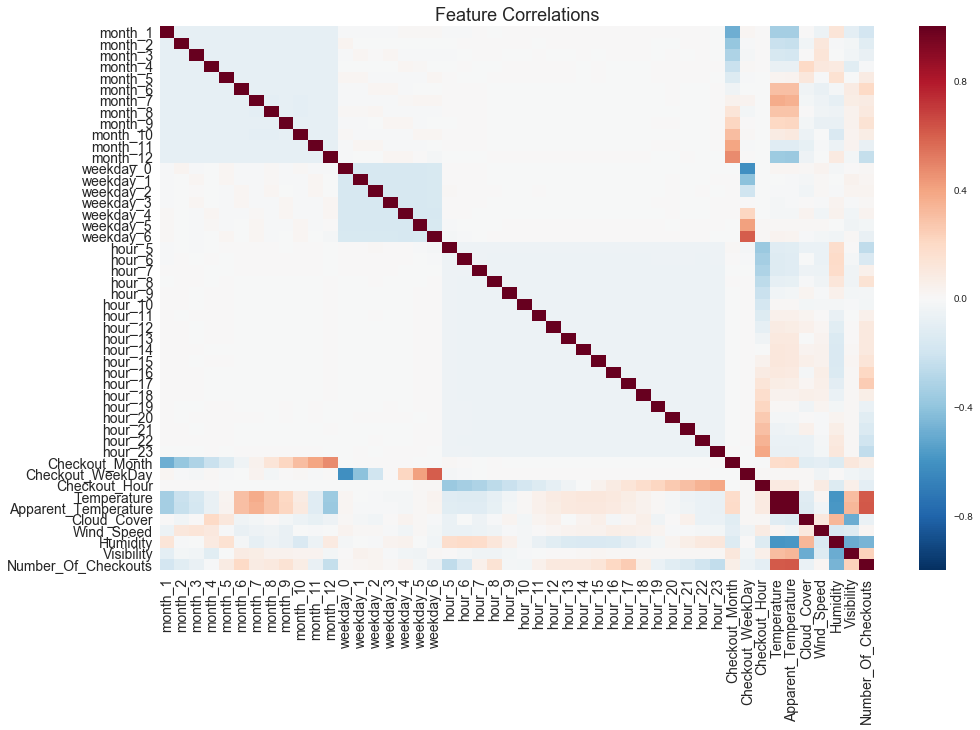

In [49]:
plt.figure(figsize=(16,10))
ax = sns.heatmap(data.corr())
plt.title("Feature Correlations", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [50]:
features = ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data['Number_Of_Checkouts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

## 2. Modeling - All Features

### Plot Feature Importance

In [51]:
def plot_feature_importances(model, plot_title):
    n_features = X.shape[1]
    plt.figure(figsize=(10,14))
    feature_importance = model.feature_importances_
    features_list = features
    feature_importance, features_list = zip(*sorted(zip(feature_importance, features_list)))
    plt.barh(range(len(features_list)), feature_importance, align='center')
    plt.xticks(fontsize=14)
    plt.yticks(np.arange(len(features_list)), features_list, fontsize=14)
    plt.xlabel('Relative Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title(plot_title + ' Features Importance', fontsize=20)
    plt.show()

### Get Regression Metrics

In [52]:
#def get_regression_metrics(model, actual, predicted):
#    regression_metrics = {'R Squared' : metrics.r2_score(actual, predicted)}
#    dML_metrics = pd.DataFrame.from_dict(regression_metrics, orient='index')
#    dML_metrics.columns = [model]
#    return dML_metrics

In [53]:
def get_regression_metrics(model, actual, predicted):
    regression_metrics = {'R Squared' : metrics.r2_score(actual, predicted)**0.5,
                          'RMSE' : metrics.mean_squared_error(actual, predicted)}
    dML_metrics = pd.DataFrame.from_dict(regression_metrics, orient='index')
    dML_metrics.columns = [model]
    return dML_metrics

### Linear Regression

In [54]:
# Linear Regression
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
print("lr.intercept_: {}".format(lr.intercept_))
print("lr.coef_: {}".format(lr.coef_))
print("\nTraining Set Score: {:.3f}".format(lr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lr.score(X_test, y_test)))
lr_metrics = get_regression_metrics('Linear Regression', y_test, y_predict)
lr_metrics

lr.intercept_: 98847970363.7425
lr.coef_: [ -3.58248332e+06  -3.58248234e+06  -3.58247912e+06  -3.58247458e+06
  -3.58247338e+06  -3.58247565e+06  -3.58249547e+06  -3.58248755e+06
  -3.58247792e+06  -3.58247786e+06  -3.58248593e+06  -3.58249237e+06
  -2.50097996e+11  -2.50097996e+11  -2.50097996e+11  -2.50097996e+11
  -2.50097996e+11  -2.50097996e+11  -2.50097996e+11   1.51253608e+11
   1.51253608e+11   1.51253608e+11   1.51253608e+11   1.51253608e+11
   1.51253608e+11   1.51253608e+11   1.51253608e+11   1.51253608e+11
   1.51253608e+11   1.51253608e+11   1.51253608e+11   1.51253608e+11
   1.51253608e+11   1.51253608e+11   1.51253608e+11   1.51253608e+11
   1.51253608e+11   1.51253608e+11   1.39476516e-01   9.55970885e-01
  -3.72469747e+00  -2.96784108e-01  -7.18614990e+00   1.68708286e+00]

Training Set Score: 0.676
Testing Set Score: 0.696


,Linear Regression
R Squared,0.834519
RMSE,627.954399


In [55]:
#dX = pd.DataFrame(lr.coef_, features)
#dX.sort_values(by=0)

### Lasso Regression

In [56]:
# Lasso Regression
lso = linear_model.Lasso(alpha=0.01)
lso.fit(X_train, y_train)
y_predict = lso.predict(X_test)
print("lso.intercept_: {}".format(lso.intercept_))
print("lso.coef_: {}".format(lso.coef_))
print("Training Set Score: {:.3f}".format(lso.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lso.score(X_test, y_test)))
lso_metrics = get_regression_metrics('Lasso Regression', y_test, y_predict)
lso_metrics

lso.intercept_: -1.5014104782456315
lso.coef_: [ -1.67856259  -0.81606643   2.03695912   6.27729376   7.27583712
   4.67182451 -14.98633311  -6.96772419   2.5931117    2.94666152
  -4.53888289 -10.63849187  -1.61426042   0.           1.4169881
   0.53712395   2.03715393  -4.38806834 -11.98416985 -43.14115275
 -21.99938754  18.20817589  31.79294194  -4.45134787 -10.51780979  -0.
   5.34609851   4.6353157    3.20290551   9.10844907  24.05081284
  35.71554191   3.31265665 -17.60886983 -23.58714936 -27.29721963
 -36.07230659 -44.4488552    0.17154211   0.95365994  -2.88745866
  -0.29334085  -6.2997122    1.72462618]
Training Set Score: 0.676
Testing Set Score: 0.696


,Lasso Regression
R Squared,0.834457
RMSE,628.168261


### Ridge Regression

In [57]:
# Ridge Regression
rge = linear_model.Lasso(alpha=0.01)
rge.fit(X_train, y_train)
y_predict = rge.predict(X_test)
print("rge.intercept_: {}".format(rge.intercept_))
print("rge.coef_: {}".format(rge.coef_))
print("Training Set Score: {:.3f}".format(rge.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rge.score(X_test, y_test)))
rge_metrics = get_regression_metrics('Ridge Regression', y_test, y_predict)
rge_metrics

rge.intercept_: -1.5014104782456315
rge.coef_: [ -1.67856259  -0.81606643   2.03695912   6.27729376   7.27583712
   4.67182451 -14.98633311  -6.96772419   2.5931117    2.94666152
  -4.53888289 -10.63849187  -1.61426042   0.           1.4169881
   0.53712395   2.03715393  -4.38806834 -11.98416985 -43.14115275
 -21.99938754  18.20817589  31.79294194  -4.45134787 -10.51780979  -0.
   5.34609851   4.6353157    3.20290551   9.10844907  24.05081284
  35.71554191   3.31265665 -17.60886983 -23.58714936 -27.29721963
 -36.07230659 -44.4488552    0.17154211   0.95365994  -2.88745866
  -0.29334085  -6.2997122    1.72462618]
Training Set Score: 0.676
Testing Set Score: 0.696


,Ridge Regression
R Squared,0.834457
RMSE,628.168261


### Bayesian Ridge Regression

In [58]:
# Bayesian Ridge Regressor
brr = linear_model.BayesianRidge()
brr.fit(X_train, y_train)
y_predict = brr.predict(X_test)
print("brr.intercept_: {:.3f}".format(brr.intercept_))
print("brr.coef_: {}".format(brr.coef_))
print("Training Set Score: {:.3f}".format(brr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(brr.score(X_test, y_test)))
brr_metrics = get_regression_metrics('Bayesion Ridge Regression', y_test, y_predict)
brr_metrics

brr.intercept_: -7.734
brr.coef_: [ -9.19101721e-01  -1.16197032e-02   3.12491823e+00   7.50756294e+00
   8.62636944e+00   6.17353089e+00  -1.35331550e+01  -5.63916723e+00
   3.99952886e+00   4.17237498e+00  -3.65499465e+00  -9.84624701e+00
   3.30019161e-01   1.98963541e+00   3.45533810e+00   2.59571489e+00
   4.09061761e+00  -2.44019006e+00  -1.00211351e+01  -3.80054749e+01
  -1.71073479e+01   2.30425191e+01   3.64971893e+01   2.93587943e-01
  -5.71783642e+00   4.88832753e+00   1.03730484e+01   9.66463597e+00
   8.26995753e+00   1.41008317e+01   2.88548772e+01   4.04111197e+01
   8.36247681e+00  -1.27287811e+01  -1.86363716e+01  -2.22814637e+01
  -3.10040219e+01  -3.92772737e+01   1.51157486e-01   9.57813936e-01
  -3.28867277e+00  -2.93930306e-01  -7.20411241e+00   1.67318296e+00]
Training Set Score: 0.676
Testing Set Score: 0.696


,Bayesion Ridge Regression
R Squared,0.834448
RMSE,628.198327


### Decision Tree Regression

In [59]:
# Decision Tree Regressor
dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X_train, y_train)
y_predict = dtr.predict(X_test)
print("Training Set Score: {:.3f}".format(dtr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(dtr.score(X_test, y_test)))
dtr_metrics = get_regression_metrics('Decision Tree Regression', y_test, y_predict)
dtr_metrics

Training Set Score: 1.000
Testing Set Score: 0.718


,Decision Tree Regression
R Squared,0.847276
RMSE,583.574453


### Random Forest Regression

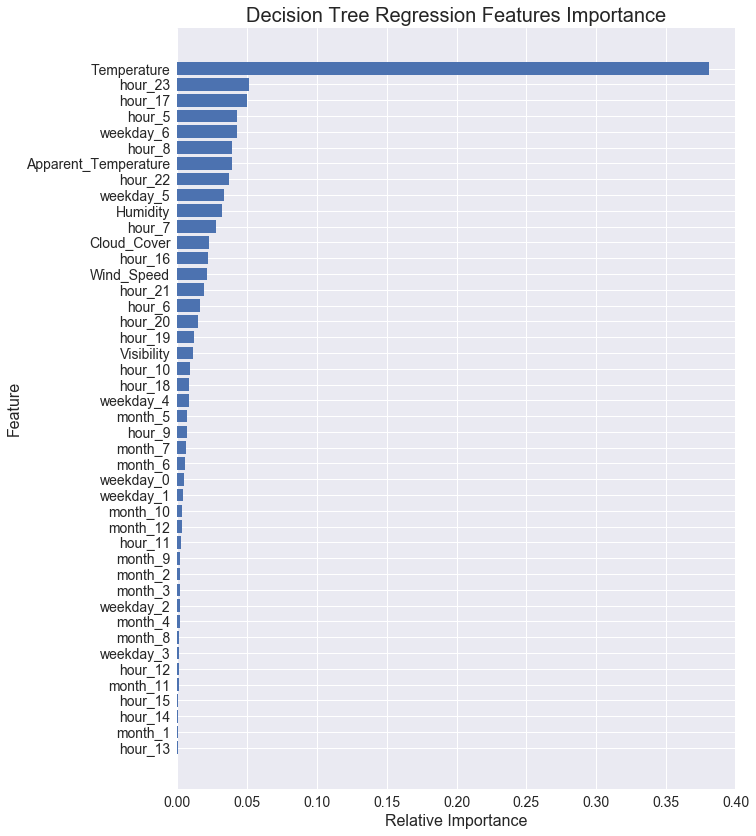

In [60]:
plot_feature_importances(dtr, 'Decision Tree Regression')

In [61]:
# Random Forest Regressor
rfr = RandomForestRegressor(random_state=0)
rfr.fit(X_train, y_train)
y_predict = rfr.predict(X_test)
print("Training Set Score: {:.3f}".format(rfr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rfr.score(X_test, y_test)))
rfr_metrics = get_regression_metrics('Random Forest Regression', y_test, y_predict)
rfr_metrics

Training Set Score: 0.969
Testing Set Score: 0.825


,Random Forest Regression
R Squared,0.908443
RMSE,361.434854


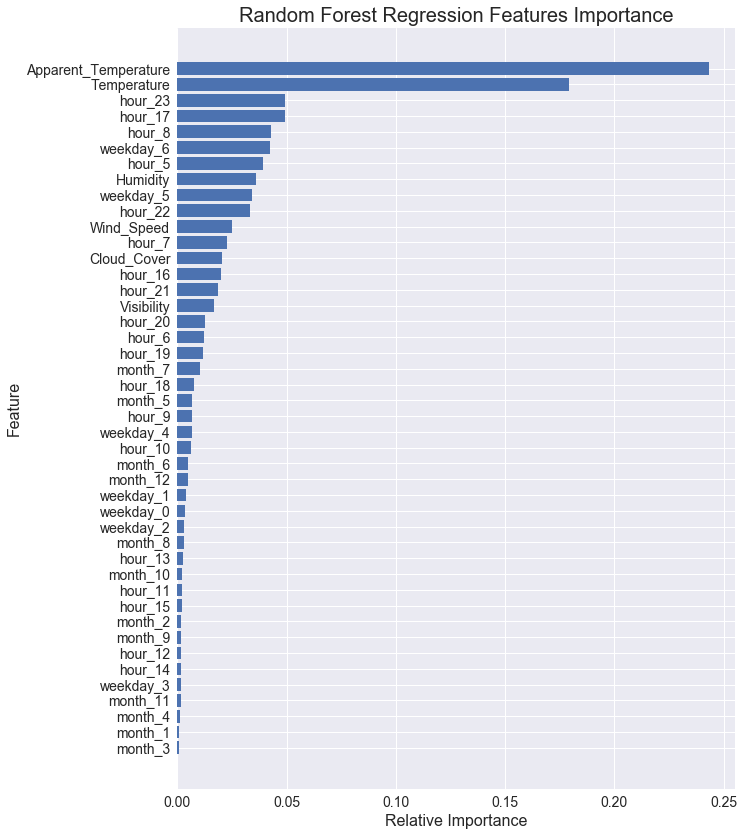

In [62]:
plot_feature_importances(rfr, 'Random Forest Regression')

#### Extra Trees Regression

In [ ]:
# Extra Trees Regressor
etr = ExtraTreesRegressor(random_state=0)
etr.fit(X_train, y_train)
y_predict = etr.predict(X_test)
print("Training Set Score: {:.3f}".format(etr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(etr.score(X_test, y_test)))
etr_metrics = get_regression_metrics('Extra Trees Regression', y_test, y_predict)
etr_metrics

Training Set Score: 1.000
Testing Set Score: 0.840


,Extra Trees Regression
R Squared,0.916278
RMSE,331.860358


In [ ]:
plot_feature_importances(etr, 'Extra Trees Regression')

#### Nearest Neighbors Regression

In [ ]:
# Nearest Neighbors Regressor
knr = KNeighborsRegressor(n_neighbors=10)
knr.fit(X_train, y_train)
y_predict = knr.predict(X_test)
print("Training Set Score: {:.3f}".format(knr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(knr.score(X_test, y_test)))
knr_metrics = get_regression_metrics('Nearest Neighbors Regression', y_test, y_predict)
knr_metrics

## Regression Summary - Categorical Feature Set

In [ ]:
# Regression Summary
print("Regression Summary - Categorical Feature Set")
regression_metrics = pd.concat([lr_metrics, lso_metrics, rge_metrics, brr_metrics,
                                dtr_metrics, rfr_metrics, etr_metrics, knr_metrics] , axis=1)
regression_metrics.sort_index()

## 3. Modeling - Selected Features

In [ ]:
data = dML.copy(deep=True)

In [ ]:
data.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility'}, inplace = True)

In [ ]:
features = ['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',  
            'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility',
            'Number_Of_Checkouts']
plt.figure(figsize=(10,6))
ax = sns.heatmap(data.corr())
plt.title("Feature Correlations", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
data = data[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility', 'Number_Of_Checkouts']]

In [ ]:
features = ['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',  
            'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data['Number_Of_Checkouts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [ ]:
array = data.values
X = array[:,0:9]
X[0]

In [ ]:
y = array[:,9]
y[0]

In [ ]:
features = ["Checkout_Month", "Checkout_WeekDay", 'Checkout_Hour', 'Temperature', 
            'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data["Number_Of_Checkouts"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [ ]:
def plot_feature_importances(model, plot_title):
    n_features = X.shape[1]
    plt.figure(figsize=(10,6))
    feature_importance = model.feature_importances_
    features_list = features
    feature_importance, features_list = zip(*sorted(zip(feature_importance, features_list)))
    plt.barh(range(len(features_list)), feature_importance, align='center')
    plt.xticks(fontsize=14)
    plt.yticks(np.arange(len(features_list)), features_list, fontsize=14)
    plt.xlabel('Relative Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title(plot_title + ' Features Importance', fontsize=20)
    plt.show()

### Linear Regression

In [ ]:
# Linear Regression
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print("\nTraining Set Score: {:.3f}".format(lr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lr.score(X_test, y_test)))
lr_metrics = get_regression_metrics('Linear Regression', y_test, y_predict)
lr_metrics

In [ ]:
#lr.predict(Xy)

### Lasso Regression

In [ ]:
# Lasso Regression
lso = linear_model.Lasso(alpha=0.1)
lso.fit(X_train, y_train)
y_predict = lso.predict(X_test)
print("Training Set Score: {:.3f}".format(lso.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lso.score(X_test, y_test)))
lso_metrics = get_regression_metrics('Lasso Regression', y_test, y_predict)
lso_metrics

### Ridge Regression

In [ ]:
# Ridge Regression
rge = linear_model.Lasso(alpha=0.1)
rge.fit(X_train, y_train)
y_predict = rge.predict(X_test)
print("Training Set Score: {:.3f}".format(rge.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rge.score(X_test, y_test)))
rge_metrics = get_regression_metrics('Ridge Regression', y_test, y_predict)
rge_metrics

### Bayesian Ridge Regression

In [ ]:
# Bayesian Ridge Regression
brr = linear_model.BayesianRidge()
brr.fit(X_train, y_train)
y_predict = brr.predict(X_test)
print("Training Set Score: {:.3f}".format(brr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(brr.score(X_test, y_test)))
brr_metrics = get_regression_metrics('Bayesion Ridge Regression', y_test, y_predict)
brr_metrics

### Decision Tree Regression

In [ ]:
# Decision Tree Regression
dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X_train, y_train)
y_predict = dtr.predict(X_test)
print("Training Set Score: {:.3f}".format(dtr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(dtr.score(X_test, y_test)))
dtr_metrics = get_regression_metrics('Decision Tree', y_test, y_predict)
dtr_metrics

In [ ]:
plot_feature_importances(dtr, 'Decision Tree Regression')


### Random Forest Regression

In [ ]:
# Random Forest Regression
rfr = RandomForestRegressor(random_state=0)
rfr.fit(X_train, y_train)
y_predict = rfr.predict(X_test)
print("Training Set Score: {:.3f}".format(rfr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rfr.score(X_test, y_test)))
rfr_metrics = get_regression_metrics('Random Forest Regression', y_test, y_predict)
rfr_metrics

In [ ]:
plot_feature_importances(rfr, 'Random Forest Regression')

### Extra Trees Regression

In [ ]:
# Extra Trees Regression
etr = ExtraTreesRegressor(random_state=0)
etr.fit(X_train, y_train)
y_predict = etr.predict(X_test)
print("Training Set Score: {:.3f}".format(etr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(etr.score(X_test, y_test)))
etr_metrics = get_regression_metrics('Extra Trees Regression', y_test, y_predict)
etr_metrics

In [ ]:
etr.predict(Xy)

In [ ]:
plot_feature_importances(etr, 'Extra Trees Regression')

### Nearest Neighbors Regression

In [ ]:
# Nearest Neighbors Regression
knr = KNeighborsRegressor(n_neighbors=2)
knr.fit(X_train, y_train)
y_predict = knr.predict(X_test)
print("Training Set Score: {:.3f}".format(knr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(knr.score(X_test, y_test)))
knr_metrics = get_regression_metrics('Nearest Neighbors Regression', y_test, y_predict)
knr_metrics

## Regression Summary with Numeric Feature Set

In [ ]:
# Regression Summary
print("Regression Summary With Numeric Feature Set")
regression_metrics = pd.concat([lr_metrics, lso_metrics, rge_metrics, brr_metrics, dtr_metrics,
                                rfr_metrics, etr_metrics, knr_metrics] , axis=1)
regression_metrics.sort_index()

## 4. Summary

With reduced features, the Random Forest model attains the highest accuracy with the lowest RMSE. The linear models have almost four times higher RMSE values as compared to the Random Forest model. This suggests that the prediction can be improved with reduced features.